In [1]:
import pandas as pd
import pickle
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data
from modules import *
from base import BaseObjective

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# # Load the pre-trained BERT model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# model = AutoModel.from_pretrained('bert-base-uncased')

# # Create a sample dataframe with messages and their labels
# df = pd.read_csv('data/spam.csv', encoding='ISO-8859-1', usecols=[0, 1]).rename(columns={'v2': 'message', 'v1': 'label'})
# # Define a function to generate embeddings for a given message
# def generate_embedding(message):
#     # Tokenize the message and convert to tensors
#     input_ids = torch.tensor([tokenizer.encode(message, add_special_tokens=True)])
#     # Generate the BERT embeddings
#     with torch.no_grad():
#         outputs = model(input_ids)
#         last_hidden_states = outputs.last_hidden_state[0]
#     # Return the mean of the embedding vectors
#     return torch.mean(last_hidden_states, dim=0)

# # Apply the generate_embedding function to all messages in the dataframe
# # tqdm.pandas(desc="Processing rows")
# # df['embedding'] = df['message'].progress_apply(generate_embedding)

# # Print the updated dataframe
# # print(df)



2023-05-09 11:27:39.705153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 11:27:40.669882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
with open('data/spambert.pkl', 'rb') as f:
    df = pickle.load(f)
df['label'] = df['label'].replace({'spam': 1, 'ham': 0})

In [26]:
X=torch.stack(df.embedding.tolist())
y=df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
# 54- birthdate

In [27]:
text_train = df.message[y_train.index].tolist()
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train.tolist()).type('torch.FloatTensor')

text_test = df.message[y_test.index].tolist()
y_test = torch.tensor(y_test.tolist()).type('torch.FloatTensor')
X_test = torch.tensor(X_test)

/tmp/ipykernel_111634/2161654357.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
/tmp/ipykernel_111634/2161654357.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)


In [33]:
text_test[810]

"Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?"

In [34]:
L2_WEIGHT = 1e-4
def fit_model(X, Y):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000)
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(768, 1, bias=True)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Flatten(start_dim=-2),
        nn.Sigmoid()
    )

    pt_clf = pt_clf.to(device=DEVICE, dtype=torch.float32)
    return pt_clf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)
clf = fit_model(X_train, y_train)

In [35]:
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
    
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [36]:
import torch.nn.functional as F
def df_construct(test_idx, train_idxs):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    similarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]
    
    data = {'Influence': influences.reshape(-1).tolist(), 'Similarity': similarity, 'Label':y_train.tolist(), 
            'X_train':X_train.numpy().tolist(), 'message':text_train}
    df = pd.DataFrame(data)
    return df
test_idx = 810
train_idxs = list(range(X_train.shape[0]))
df = df_construct(test_idx, train_idxs)

In [37]:
df.sort_values('Influence', ascending=False)[:20]

,Influence,Similarity,Label,X_train,message
1457,0.155533,0.754326,1.0,"[0.15220767259597778, 0.016744835302233696, 0....",How come it takes so little time for a child w...
3599,0.115487,0.757112,1.0,"[0.5914867520332336, 0.09932857006788254, 0.31...","Do you realize that in about 40 years, we'll h..."
3649,0.086105,0.685927,1.0,"[0.01703137345612049, 0.08021598309278488, 0.3...",ROMCAPspam Everyone around should be respondin...
4037,0.059039,0.655902,1.0,"[0.36751672625541687, -0.27865609526634216, 0....","Latest News! Police station toilet stolen, cop..."
36,0.050644,0.652599,1.0,"[0.031901538372039795, -0.22547005116939545, 0...",Hello darling how are you today? I would love ...
4166,0.041955,0.647183,1.0,"[0.20349331200122833, 0.038227248936891556, 0....",Guess who am I?This is the first time I create...
2688,0.038725,0.589443,1.0,"[0.005458405241370201, -0.05664324760437012, 0...","Did you hear about the new \Divorce Barbie\""? ..."
2356,0.038067,0.607875,1.0,"[0.13453912734985352, -0.10220804810523987, 0....",This message is brought to you by GMW Ltd. and...
2743,0.038044,0.678001,1.0,"[0.4786458909511566, -0.11260329931974411, 0.4...",Would you like to see my XXX pics they are so ...
4180,0.035218,0.582754,1.0,"[0.33021482825279236, 0.16650575399398804, 0.2...","accordingly. I repeat, just text the word ok o..."


In [38]:
def input_data(df, test_idx, sett=None):
    
    scaler = MinMaxScaler()
    
    influence_pos = [i for i in df.Influence.tolist() if i>0]
    q3p, q1p = np.percentile(influence_pos, [75 ,25])
    iqrp = q3p - q1p
    influenceIQp=np.array([i for i in influence_pos if i>q3p+3*iqrp])
    n_p=len(influenceIQp)
    
    influence_neg = [i for i in df.Influence.tolist() if i<0]
    q3n, q1n = np.percentile(influence_neg, [75 ,25])
    iqrn = q3n - q1n
    influenceIQn=np.array([i for i in influence_neg if i<q1n-2*iqrn])
    nn=len(influenceIQn)
    
    if sett == 'positive':

        df_pos = df[df.Influence>0].sort_values('Influence', ascending=False) #.reset_index(drop=True)
        df_pos[['Influence', 'Similarity']]= scaler.fit_transform(df_pos[['Influence', 'Similarity']])
        df_pos_sl = df_pos[df_pos.Label==y_test[test_idx].item()][:n_p]
        df_pos_ol = df_pos[df_pos.Label!=y_test[test_idx].item()][:n_p]
        
        return df_pos_sl, df_pos_ol
    
    elif sett=='negative':
       
        df_neg = df[df.Influence<0].sort_values('Influence', ascending=True) #.reset_index(drop=True)
        df_neg[['Influence', 'Similarity']]= scaler.fit_transform(df_neg[['Influence', 'Similarity']])
        df_neg_sl = df_neg[df_neg.Label==y_test[test_idx].item()][:nn]
        df_neg_ol = df_neg[df_neg.Label!=y_test[test_idx].item()][:nn]
        
        return df_neg_ol, df_neg_sl

In [39]:
def calculate_cosine_similarity(a, b):
    """Calculate cosine similarity between two arrays."""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def greedy_subset_selection(df, N, sett=None, label=None):
    
    arrays = [np.array(i) for i in df.X_train]
    influence_scores = df.Influence.tolist()  # List of influence scores for each array
    prox = df.Similarity.tolist()
    n_arrays = len(arrays)
    selected_indices = []
    wi=0.2
    ws=0.9
    wd=0.3
    # Start with the array with the highest influence score
    # Start with the array with the highest influence score
    if sett =='positive' and label=='opposite':
        initial_idx = np.argmax(influence_scores)
    elif sett =='positive' and label=='same':
        initial_idx = np.argmax(prox)
    if sett =='negative' and label=='opposite':
        initial_idx = np.argmax(prox)
    elif sett =='negative' and label=='same':
        initial_idx = np.argmin(prox)
    selected_indices.append(initial_idx)
    selected_array = arrays[initial_idx]
    
    while len(selected_indices) < N:
        max_gain = -np.inf
        selected_idx = None
        
        # Iterate over the remaining arrays
        for i in range(n_arrays):
            if i not in selected_indices:
                current_array = arrays[i]
                final_list = list(map(lambda x: calculate_cosine_similarity(current_array, arrays[x]), selected_indices))
                if any(i>0.9 for i in final_list):
                    continue
                else:
                    
                    similarity = np.mean(final_list)
                    # Calculate combined score of diversity and influence score
                    if sett =='positive' and label=='same':
                        combined_score = 0.7*prox[i]+0.1*influence_scores[i]- 0.3*similarity
#                         combined_score = wi*influence_scores[i] + ws*prox[i] - wd*similarity
                    elif sett =='negative' and label=='opposite':
                        combined_score = 0.8*prox[i]-0.4*influence_scores[i]- 0.3*similarity                        
                    elif sett =='positive' and label=='opposite':
                        combined_score = 0.6*influence_scores[i]-0.8*prox[i]-0.3*similarity
#                         combined_score = wi*influence_scores[i] - wd*similarity
                    elif sett =='negative' and label=='same':
                        combined_score = -0.1*influence_scores[i]-0.8*prox[i]-0.3*similarity
                    # Update selected array if it provides the highest gain
                    if combined_score > max_gain:
                        max_gain = combined_score
                        selected_idx = i
        
        # Add selected array to the subset
        selected_indices.append(selected_idx)
    
    return selected_indices


df_pos_sl, df_pos_ol = input_data(df, test_idx, sett='positive')
df_neg_ol, df_neg_sl = input_data(df, test_idx, sett='negative')
selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=4, sett='positive', label='same')
selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=4, sett='positive', label='opposite')
selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=4, sett='negative', label='same')
selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=4, sett='negative', label='opposite')

In [11]:
selected_indices_pos_sl

[35, 1, 2, 26]

In [12]:
[df_pos_sl.index[i] for i in selected_indices_pos_sl]

[2693, 1116, 186, 2418]

In [40]:
[(df_pos_sl.message.tolist()[i], df_pos_sl.Label.tolist()[i]) for i in selected_indices_pos_sl]

[("Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?",
  1.0),
 ('How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?',
  1.0),
 ('ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.',
  1.0),
 ('Would you like to see my XXX pics they are so hot they were nearly banned in the uk!',
  1.0)]

In [41]:
[(df_pos_ol.message.tolist()[i], df_pos_ol.Label.tolist()[i]) for i in selected_indices_pos_ol]

[('I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;',
  0.0),
 ('\\ER', 0.0),
 ('ALRITE', 0.0),
 ('He remains a bro amongst bros', 0.0)]

In [42]:
[(df_neg_ol.message.tolist()[i], df_neg_ol.Label.tolist()[i]) for i in selected_indices_neg_ol]

[("Idk. I'm sitting here in a stop and shop parking lot right now bawling my eyes out because i feel like i'm a failure in everything. Nobody wants me and now i feel like i'm failing you.",
  0.0),
 ('My slave! I want you to take 2 or 3 pictures of yourself today in bright light on your cell phone! Bright light!',
  0.0),
 ('Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens',
  0.0),
 ("Good morning, my boytoy! How's those yummy lips ? Where's my sexy buns now ? What do you do ? Do you think of me ? Do you crave me ? Do you need me ?",
  0.0)]

In [43]:
[(df_neg_sl.message.tolist()[i], df_neg_sl.Label.tolist()[i]) for i in selected_indices_neg_sl]

[("RCT' THNQ Adrian for U text. Rgds Vatian", 1.0),
 ('Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply.',
  1.0),
 ('FreeMsg>FAV XMAS TONES!Reply REAL', 1.0),
 ('Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP charge) See o2.co.uk/games 4 Terms + settings. No purchase',
  1.0)]

/user/cs.aau.dk/em63by/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/user/cs.aau.dk/em63by/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


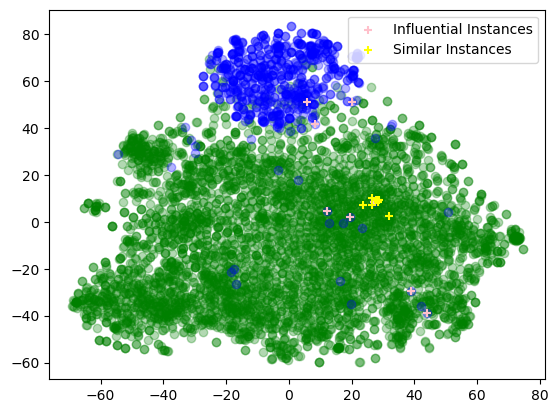

In [45]:
# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=42)

# Combine the training and test tensors
X = torch.cat((X_train, X_test), dim=0)
y = torch.cat((y_train, y_test), dim=0)

# Convert the tensors to numpy arrays
X = X.numpy()
y = y.numpy()

# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data to 2D
X_2d = tsne.fit_transform(X)

# Plot the data in 2D with different colors and alpha values for each class
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], color='green', alpha=0.3)
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], color='blue', alpha=0.3)

plt.scatter(X_2d[len(y_train)+test_idx][0], X_2d[len(y_train)+test_idx][1], marker='.', color='red')

# plt.scatter([X_2d[df_pos_sl.index[i]][0] for i in selected_indices_pos_sl],
#         [X_2d[df_pos_sl.index[i]][1] for i in selected_indices_pos_sl], marker='x', color='black', label='Explain by Relevance')

# plt.scatter([X_2d[df_pos_ol.index[i]][0] for i in selected_indices_pos_ol],
#         [X_2d[df_pos_ol.index[i]][1] for i in selected_indices_pos_ol], marker='x', color='orange', label='Explain by Contrast')

# plt.scatter([X_2d[df_neg_sl.index[i]][0] for i in selected_indices_neg_sl],
#         [X_2d[df_neg_sl.index[i]][1] for i in selected_indices_neg_sl], marker='+', color='black', label='Oppose by Contrast')

# plt.scatter([X_2d[df_neg_ol.index[i]][0] for i in selected_indices_neg_ol],
#         [X_2d[df_neg_ol.index[i]][1] for i in selected_indices_neg_ol], marker='+', color='orange', label='Oppose by Relevance')

plt.scatter([X_2d[df_pos_sl.index[i]][0] for i in range(8)], [X_2d[df_pos_sl.index[i]][1] for i in range(8)],
            marker='+', color='pink', label='Influential Instances')
plt.scatter([X_2d[df.sort_values('Similarity', ascending=False).index[i]][0] for i in range(8)], [X_2d[df.sort_values('Similarity', ascending=False).index[i]][1] for i in range(8)],
            marker='+', color='yellow', label='Similar Instances')

plt.legend()
plt.show()

In [ ]:
[X_2d[df_pos_sl.index[i]][1] for i in range(8)]

In [ ]:
selected_indices_pos_ol

In [ ]:
X_train[3027]